# Obstacle Detection (IEEE-ICRCV 2023)

##### if crashed for Open3D visualization on jupyter notebook, use it to solve: https://github.com/isl-org/Open3D/issues/1598

In [1]:
# img_bgr = cv2.imread(r'./data/image/0251.jpg') # BGR
# cv2.imshow('bgr', img_bgr)

# ### HSV ###
# img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV) # HSV
# img_hsv[:, :, 2] = 255 # H S V
# img_bgr = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR) # BGR

# ### YCrCb ###
# # img_ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCR_CB) # YCrCb
# # img_ycrcb[:, :, 0] = 255 # Y Cr Cb
# # img_bgr = cv2.cvtColor(img_ycrcb, cv2.COLOR_YCR_CB2BGR) # BGR

# ### grayscale ###
# # gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
# # ### monochrome ###
# # ret, mono = cv2.threshold(gray, 70, 105, cv2.THRESH_BINARY) # 1: org, 2: threshold, 3: setted value when greater than shreshold, 4: method 


# cv2.imshow('processed bgr', img_bgr)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [3]:
import numpy as np
import cv2
from utils.point_cloud_process import viz_o3d_pc, np_pc_to_o3d_pc, o3d_pc_to_np_pc, calc_outlier, depth_to_pc
from utils.point_cloud_process import viz_inlier_outlier, calc_array2d_diff, calc_array2d_diff_index, cal_color, np_to_o3d
from utils.point_cloud_process import box_intersection_volume
import matplotlib.pyplot as plt
%matplotlib inline
import open3d as o3d
import time
import numpy as np
# import k3d
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, DBSCAN
from scipy.signal import find_peaks


# torchvision object detection: https://pytorch.org/vision/stable/models.html#object-detection
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import cv2
import os
import numpy as np
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights, fasterrcnn_resnet50_fpn
from torchvision.transforms.functional import to_pil_image

### just an example for point cloud file reading

In [10]:
# # just a example 
# pcd__ = o3d.io.read_point_cloud(r'./data/tabletop_scene.ply') 
# plane_model__, plane_index__ = pcd__.segment_plane(distance_threshold=0.005, ransac_n=3, num_iterations=500)
# # road -> black
# road_pcd__ = pcd__.select_by_index(plane_index__)
# road_pcd__.paint_uniform_color([0, 0, 0])
# print('road:', road_pcd__)
# # outlier(obstacle) -> blue
# obstacle_pcd__ = pcd__.select_by_index(plane_index__, invert=True)
# obstacle_pcd__.paint_uniform_color([0, 0, 1])
# print('obstacle:', obstacle_pcd__)
# viz_o3d_pc([road_pcd__, obstacle_pcd__])

## 1. read rgb & left_right & disparity & depth map (.npy)
### 0001

In [11]:
# # (H:400, W:640)
# disparity = np.load('./data/0000/disparity_4.npy')
# depth = np.load('./data/0000/depth_4.npy')


#### 220~399 (180), 1100~1199 (100), 1500~1599 (100), 3900~4099 (200), 4500~4599 (100), (H:720, W:1280)
# # e.g. 1
# directory_id, file_id = '0001', '00' # bottle
# rgb = np.load('./data/{}/rgb{}.npy'.format(directory_id, '00'))

# # e.g. 2
# directory_id, file_id = '0001', 245 # person

# # e.g. 3
# directory_id, file_id = '0001', 255 # person

# # e.g. 4
# directory_id, file_id = '0001', 266 # bottle & wallet

# e.g. 5
directory_id, file_id = '0001', 270 # bottle & wallet

# # e.g. 6
# directory_id, file_id = '0001', 1160 # traffic cone

# # e.g. 7
# directory_id, file_id = '0001', 1515 # person & bottle

# # e.g. 8
# directory_id, file_id = '0001', 4100 # pole

# # e.g. 9
# directory_id, file_id = '0001', 4596 # vehicle

# directory_id, file_id = '0001', 273 # person: (250, 256, 261), wallet, bottle: (265, 269, 273) # 電気学会発表
# rgb = np.load('./data/{}/rgb{}.npy'.format(directory_id, a - 6))

rgb = np.load('./data/{}/rgb{}.npy'.format(directory_id, file_id-6))
leftright = np.load('./data/{}/leftright{}.npy'.format(directory_id, file_id))
disparity = np.load('./data/{}/disparity{}.npy'.format(directory_id, file_id))
depth = np.load('./data/{}/depth{}.npy'.format(directory_id, file_id))

print('rgb', rgb.shape, rgb.min(), rgb.max(), rgb.dtype)
print('leftright', leftright.shape, leftright.min(), leftright.max(), leftright.dtype)
print('disparity', disparity.shape, disparity.min(), disparity.max(), disparity.dtype)
print('depth', depth.shape, depth.min(), depth.max(), depth.dtype)

rgb (720, 1280, 3) 0 255 uint8
leftright (720, 1280) 0 255 uint8
disparity (720, 1280) 0 95 uint8
depth (720, 1280) 0 16546 uint16


### viz rgb

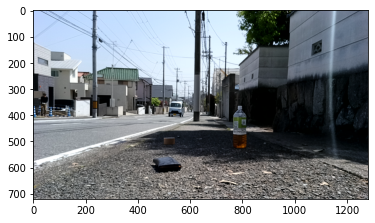

In [12]:
plt.imshow(rgb[:, :, ::-1])
plt.show()
# cv2.imwrite(r'./utils/1.png', rgb)

c:\Users\zhang\.conda\envs\Dance\lib\site-packages\torchvision\utils.py:237: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


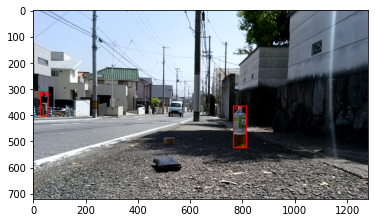

In [22]:
# img = read_image('test/assets/encode_jpeg/grace_hopper_517x606.jpg')
img = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB) # 将BGR转换成RGB
img = np.transpose(img, (2, 0, 1)) # [高，宽，通道数] 转 [通道数，高，宽]
img = torch.from_numpy(img) # numpy 转 tensor

# Step 1: Initialize model with the best available weights
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = [preprocess(img)]

# Step 4: Use the model and visualize the prediction
prediction = model(batch)[0]


labels = [weights.meta["categories"][i] for i in prediction["labels"]]
# 带有box的图片
box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4, font_size=30)
im = to_pil_image(box.detach())
plt.imshow(im)
plt.show()
# im.save(r'./utils/1.png')

764 364 816 526
27 311 58 404


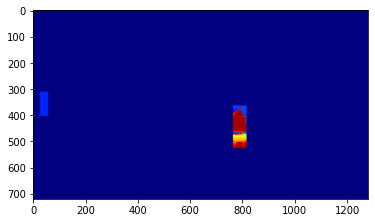

In [23]:
# create mask for depth
mask_depth = np.zeros(depth.shape)
mask_disparity = np.zeros(depth.shape)

for i in range(len(prediction['boxes'])): 
    prediction['boxes'][i], prediction['labels'][i], prediction['scores'][i], labels[i]
    x1, y1, x2, y2 = prediction['boxes'][i] # 左上角，右下角
    x1, y1, x2, y2 = int(x1.item()), int(y1.item()), int(x2.item()), int(y2.item())
    print(x1, y1, x2, y2)
    ##### calc mask
    mask_depth[y1:y2, x1:x2] = 1 
    mask_disparity[y1:y2, x1:x2] = 1 
    depth_object = (mask_depth * depth).astype(np.uint16)
    disparity_object = (mask_disparity * disparity).astype(np.uint8) 
    # save mask npy
    np.save('./data/{}/depth_object{}'.format(directory_id, file_id), depth_object)

# viz
disparityMultiplier = 255 / disparity_object.max()
disparity_object = (disparity_object * disparityMultiplier).astype(np.uint8) # mono disparity
disparity_object = cv2.applyColorMap(disparity_object, cv2.COLORMAP_JET) # color disparity
plt.imshow(disparity_object[:, :, ::-1])
plt.show()
# cv2.imwrite(r'./utils/1.png', disparity_object)

### viz left_right

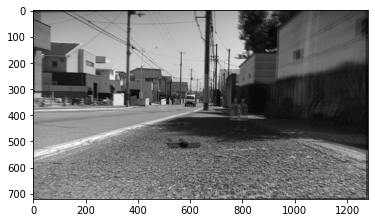

In [25]:
leftright_ = cv2.cvtColor(leftright, cv2.COLOR_GRAY2BGR) # only copy 1 channel to 3 channels  
plt.imshow(leftright_)
plt.show()
# cv2.imwrite(r'./utils/1.png', leftright)

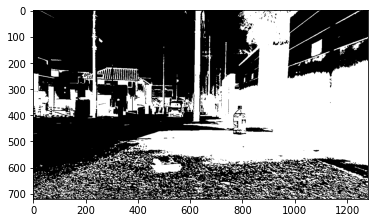

In [24]:
gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
# 阈值分割
thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)[1]
plt.imshow(thresh, cmap='gray')
plt.show()

### viz depth map via disparity

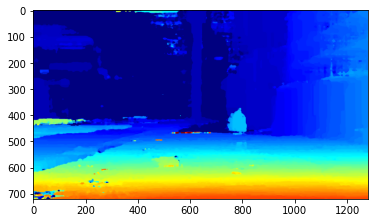

In [26]:
disparityMultiplier = 255 / disparity.max()
disparity = (disparity * disparityMultiplier).astype(np.uint8) # mono disparity
disparity = cv2.applyColorMap(disparity, cv2.COLORMAP_JET) # color disparity
plt.imshow(disparity[:, :, ::-1])
plt.show()
# cv2.imwrite(r'./utils/1.png', disparity)

### viz rgb + depth

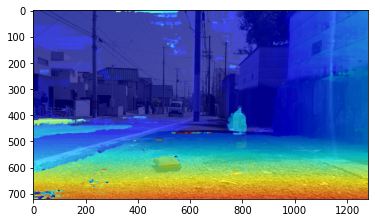

In [27]:
blend=cv2.addWeighted(disparity[:, :, ::-1], 0.7, rgb[:, :, ::-1], 0.3, 0)
plt.imshow(blend)
plt.show()
# cv2.imwrite(r'./utils/1.png', blend)

### Hyperparameters

In [28]:
'''
3x3 intrinsics matrix
fx   0   cx
0    fy  cy
0    0   1
'''
# # 400P (H:400, W:640)
# HIGHT, WIDTH  = depth.shape
# FX, FY = 795.209, 793.957 
# CX, CY = 332.031, 231.308


# 720P (H:720, W:1280)
HIGHT, WIDTH  = depth.shape
FX, FY = 3064.4104, 3064.4104 
CX, CY = 1923.0302, 1078.5358
    
INTRINSIC_MATRIX = np.array([
    [FX, 0, CX],
    [0, FY, CY],
    [0, 0, 1]
]) # 3*3
EXTRINSIC_MATRIX = np.eye(4) # 4*4

## 2. depth map -> point cloud
### rotate: depth camera format (pix coor) -> open3d point cloud format (world coor)
##### x: red, y: green, z: blue
<div>
<img src='./figs/rotate.png' width='600'/>
</div>

##### or [YouTube](https://www.google.com/search?q=depth+map+to+point+cloud&rlz=1C1TKQJ_zh-CNJP1010JP1010&oq=depth+map+to+point+cloud&aqs=chrome..69i57j0i13i512l3j0i7i30j0i30l2j0i5i30l2j0i8i30.10061j0j7&sourceid=chrome&ie=UTF-8#fpstate=ive&vld=cid:518a8acf,vid:vGr8Bg2Fda8), or [oak-d](https://github.com/luxonis/depthai-experiments/blob/master/gen2-box_measurement/projector_3d.py#L35-L38), or [formula](https://medium.com/yodayoda/from-depth-map-to-point-cloud-7473721d3f)

##### for RGB

In [29]:
##### load 
depth_object = np.load('./data/{}/depth_object{}.npy'.format(directory_id, file_id))


print('raw pc:', depth_object.shape[0]*depth_object.shape[1])
print('Depth, max:', depth_object.max(), 'min', depth_object.min())

# add x-y-z axis (open3d)
xyz_mesh = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0, 0, 0]) # 1m = 1000mm
# np -> o3d
depth_o3d = o3d.geometry.Image(depth_object)

##### intrinsic & extrinsic #####
intrinsic = o3d.camera.PinholeCameraIntrinsic(width=WIDTH, height=HIGHT, fx=INTRINSIC_MATRIX[0][0], fy=INTRINSIC_MATRIX[1][1], cx=INTRINSIC_MATRIX[0][2], cy=INTRINSIC_MATRIX[1][2])

##### A: depth -> point cloud #####
# 1: depth -> point cloud via intrinsic, 2: delet row which are all zero, 3: delet duplicate point cloud, 4: numpy point cloud -> open3d point cloud
pcd_object = o3d.geometry.PointCloud.create_from_depth_image(depth=depth_o3d, intrinsic=intrinsic, depth_scale=1000, extrinsic=EXTRINSIC_MATRIX)

# ##### B: rgb-d -> point cloud #####
# rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
# color = o3d.geometry.Image(rgb)
# depth_object = o3d.geometry.Image(depth_object)
# rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(color, depth_object, convert_rgb_to_intensity=False)
# pcd_object = o3d.geometry.PointCloud.create_from_rgbd_image(image=rgbd, intrinsic=intrinsic, extrinsic=EXTRINSIC_MATRIX)

viz_o3d_pc([xyz_mesh, pcd_object])


##### rotation: pixel -> world #####
# R = o3d.geometry.get_rotation_matrix_from_xyz([np.pi, 0, 0]) # rotate 180 degrees around x-axis 
# pcd_object = pcd_object.rotate(R, center=[0, 0, 0]) # rotate
R = np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
pcd_object.transform(R)
###
R_ = o3d.geometry.get_rotation_matrix_from_xyz([-np.pi/16, -np.pi/8, 0]) 
pcd_object = pcd_object.rotate(R_, center=[0, 0, 0]) # rotate
###

pcd_np = np.asarray(pcd_object.points)

# ##### only use points which less then 10m (z axis) #####
# z_threshold = -10 # less then 5m
# z = pcd_np[:, 2]
# pcd_np = pcd_np[z > z_threshold]
# pcd = np_pc_to_o3d_pc(pcd_np)

print('processed pc:', len(pcd_np))

x = pcd_np[:, 0]
y = pcd_np[:, 1]
z = pcd_np[:, 2]
print('X, max:', x.max(), 'min:', x.min(), 'mean:', x.mean(), 'std:', x.std())
print('Y, max:', y.max(), 'min:', y.min(), 'mean:', y.mean(), 'std:', y.std())
print('Z, max:', z.max(), 'min:', z.min(), 'mean:', z.mean(), 'std:', z.std())
viz_o3d_pc([xyz_mesh, pcd_object])

raw pc: 921600
Depth, max: 16546 min 0
processed pc: 11294
X, max: 0.5850903853735598 min: -2.9816168905709164 mean: -0.4953109036681418 std: 1.1480173690609794
Y, max: 0.3301459298137348 min: -0.155431403532301 mean: 0.021478060413710892 std: 0.09764026434387027
Z, max: -2.3047942940059647 min: -19.58493566838741 mean: -7.382358786205696 std: 5.881392066618759


##### for binocular

In [44]:
print('raw pc:', depth.shape[0]*depth.shape[1])
print('Depth, max:', depth.max(), 'min', depth.min())

# add x-y-z axis (open3d)
xyz_mesh = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.3, origin=[0, 0, 0]) # 1m = 1000mm
# np -> o3d
depth_o3d = o3d.geometry.Image(depth)

##### intrinsic & extrinsic #####
intrinsic = o3d.camera.PinholeCameraIntrinsic(width=WIDTH, height=HIGHT, fx=INTRINSIC_MATRIX[0][0], fy=INTRINSIC_MATRIX[1][1], cx=INTRINSIC_MATRIX[0][2], cy=INTRINSIC_MATRIX[1][2])

# ##### A: depth -> point cloud #####
# # 1: depth -> point cloud via intrinsic, 2: delet row which are all zero, 3: delet duplicate point cloud, 4: numpy point cloud -> open3d point cloud
# pcd = o3d.geometry.PointCloud.create_from_depth_image(depth=depth_o3d, intrinsic=intrinsic, depth_scale=1000, extrinsic=EXTRINSIC_MATRIX)

##### B: rgb-d -> point cloud #####
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
color = o3d.geometry.Image(rgb)
depth = o3d.geometry.Image(depth)
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(color, depth, convert_rgb_to_intensity=False)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(image=rgbd, intrinsic=intrinsic, extrinsic=EXTRINSIC_MATRIX)

viz_o3d_pc([xyz_mesh, pcd])


##### rotation: pixel -> world #####
# R = o3d.geometry.get_rotation_matrix_from_xyz([np.pi, 0, 0]) # rotate 180 degrees around x-axis 
# pcd = pcd.rotate(R, center=[0, 0, 0]) # rotate
R = np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
pcd.transform(R)
###
R_ = o3d.geometry.get_rotation_matrix_from_xyz([-np.pi/16, -np.pi/8, 0]) 
pcd = pcd.rotate(R_, center=[0, 0, 0]) # rotate
###

pcd_np = np.asarray(pcd.points)

# ##### only use points which less then 10m (z axis) #####
# z_threshold = -10 # less then 5m
# z = pcd_np[:, 2]
# pcd_np = pcd_np[z > z_threshold]
# pcd = np_pc_to_o3d_pc(pcd_np)

print('processed pc:', len(pcd_np))

x = pcd_np[:, 0]
y = pcd_np[:, 1]
z = pcd_np[:, 2]
print('X, max:', x.max(), 'min:', x.min(), 'mean:', x.mean(), 'std:', x.std())
print('Y, max:', y.max(), 'min:', y.min(), 'mean:', y.mean(), 'std:', y.std())
print('Z, max:', z.max(), 'min:', z.min(), 'mean:', z.mean(), 'std:', z.std())
viz_o3d_pc([xyz_mesh, pcd])

raw pc: 921600
Depth, max: 16546 min 0
processed pc: 323294
X, max: 0.5423627831089389 min: -0.5670134023608928 mean: 0.027074673169268072 std: 0.23061366212121204
Y, max: 0.42739498233349693 min: -0.29356593503781714 mean: -0.05582814992386412 std: 0.08606007286733838
Z, max: -0.7703712609705186 min: -3.3995813829156405 mean: -1.8074071437770718 std: 0.7124179200770957


### check if there are duplicates points

In [45]:
# def check_duplicates(arr):
#     # 将每一行视为一个元素
#     # 将其形状从 (n, 3) 转换为 (n,)，这样每行的元素就是一个字符串了
#     arr_view = np.ascontiguousarray(arr).view(np.dtype((np.void, arr.dtype.itemsize * arr.shape[1])))

#     # 使用unique函数来查找不同的行
#     _, idx = np.unique(arr_view, return_index=True)
    
#     # 如果idx的长度与行数相同，则没有重复行
#     return idx.shape[0] != arr.shape[0]

# print(check_duplicates(np.asarray(pcd.points)))  # 输出：True，即有重复行, # 输出：False，即没有重复行

### 隐点移除 (Hidden point removal)

[【点云处理技术之open3d】第三篇：点云的高级操作篇——点云边界框、凸包、DBSCAN聚类、平面分割和隐点移除](https://blog.csdn.net/QLeelq/article/details/122136481)

In [46]:
# diameter = np.linalg.norm(np.asarray(pcd.get_max_bound()) - np.asarray(pcd.get_min_bound()))
# # 定义用于隐藏点删除的参数，获取从给定视图中可见的所有点，可视化结果
# camera = [0, 0, diameter] 
# radius = diameter * 100
# # Get all points that are visible from given view point
# _, pt_map = pcd.hidden_point_removal(camera_location=camera, radius=radius) 
# pcd__ = pcd.select_by_index(pt_map)
# viz_o3d_pc([xyz_mesh, pcd__])
# print(pcd__)

In [47]:
# xyz_mesh = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1000, origin=[0, 0, 0]) # 1m = 1000mm

# pc = depth_to_pc(depth)
# print(pc.shape)
# viz_o3d_pc([xyz_mesh, np_pc_to_o3d_pc(pc)]) # viz raw

# pc_nonzero = pc[[not np.all(pc[i] == 0) for i in range(pc.shape[0])], :] # delet row which are all zero
# # pc_nonzero = pc[:, [not np.all(pc[:, i] == 0) for i in range(pc.shape[1])]] # delet column which are all zero
# print(pc_nonzero.shape)
# viz_o3d_pc([xyz_mesh, np_pc_to_o3d_pc(pc_nonzero)]) # viz

In [48]:
# index_x = calc_outlier(pc_nonzero[:, 0], 3)
# index_y = calc_outlier(pc_nonzero[:, 1], 3)
# index_z = calc_outlier(pc_nonzero[:, 2], 3)
# print('x, y, z, sum:', index_x.shape, index_y.shape, index_z.shape, len(index_x) + len(index_y) + len(index_z))
# index_xyz = np.union1d(np.union1d(index_x, index_y), index_z)
# print('union:', index_xyz.shape)
# pc_processed = np.delete(pc_nonzero, index_xyz, axis=0)
# print(pc_processed.shape)

# x = pc_processed[:, 0]
# y = pc_processed[:, 1]
# z = pc_processed[:, 2]
# print('max:', z.max())
# print('min:', z.min())
# print('mean:', z.mean())
# print('std:', z.std())

# viz_o3d_pc([xyz_mesh, np_pc_to_o3d_pc(pc_processed)])

## 3. downsampling: point cloud -> voxel (only when needed: e.g. 3D LiDAR)
<div>
<img src='./figs/voxel.png' width='200'/>
</div>

##### for RGB

In [50]:
downsampled_pcd_object = pcd_object.voxel_down_sample(voxel_size=0.01) # 0.01 -> 1cm
viz_o3d_pc([xyz_mesh, downsampled_pcd_object])
print(downsampled_pcd_object)

geometry::PointCloud with 1296 points.


##### for binocular

In [51]:
downsampled_pcd = pcd.voxel_down_sample(voxel_size=0.01) # 0.01 -> 1cm
viz_o3d_pc([xyz_mesh, np_pc_to_o3d_pc(o3d_pc_to_np_pc(downsampled_pcd))]) # vis via distance
# viz_o3d_pc([xyz_mesh, downsampled_pcd]) # (raw color)
print(downsampled_pcd)

geometry::PointCloud with 7298 points.


## 4. delete outliers

[reference](https://github.com/luxonis/depthai-experiments/blob/master/gen2-box_measurement/projector_3d.py#L35)

##### for RGB

In [52]:
inlier_pcd_object, inlier_index_object = downsampled_pcd_object.remove_statistical_outlier(nb_neighbors=30, std_ratio=0.1) # oak-d: 30, 0.1, AV book: 100, 0.0272, PC book: 20, 2.0
# inlier_pcd_object, inlier_index_object = downsampled_pcd_object.remove_radius_outlier(nb_points=20, radius=0.03) # 指定半径内，未满指定近邻点数的点，视为异常值
viz_inlier_outlier(downsampled_pcd_object, inlier_index_object) # viz inlier: black, outlier: red
viz_o3d_pc([xyz_mesh, inlier_pcd_object]) # viz inlier result
print(inlier_pcd_object)

geometry::PointCloud with 1205 points.


##### for binocular

In [54]:
inlier_pcd, inlier_index = downsampled_pcd.remove_statistical_outlier(nb_neighbors=30, std_ratio=0.1) # oak-d: 30, 0.1, AV book: 100, 0.0272, PC book: 20, 2.0
# inlier_pcd, inlier_index = downsampled_pcd.remove_radius_outlier(nb_points=5, radius=0.02) # 指定半径内，未满指定近邻点数的点，视为异常值
viz_inlier_outlier(downsampled_pcd, inlier_index) # viz inlier: black, outlier: red
viz_o3d_pc([xyz_mesh, np_pc_to_o3d_pc(o3d_pc_to_np_pc(inlier_pcd))]) # vis via distance
# viz_o3d_pc([xyz_mesh, inlier_pcd]) # viz inlier result (raw color)
print(inlier_pcd)

geometry::PointCloud with 4871 points.


## 5. segment road & obstacle 
### linear regression (easy to wrongly fit outliers)
<div>
<img src='./figs/regression.gif' width='400'/>
</div>

### RANSAC (hard to wrongly fit outliers, so use it fit road plane) 
[RANSAC line & plane](https://tech-deliberate-jiro.com/python-ransac/)
<div>
<img src='./figs/raw_pc.jpg' width='400'/>
</div>

### or [Ray Ground Filter, Ring Ground Filter (Autoware, for LiDAR point cloud, not Stereo point cloud)](https://www.sohu.com/a/334672903_715754), or PointNet, PointNet++, PointCNN to segmentation, or delet wall point cloud, or use segmentation

### only use "low" point cloud for plane estimation (road1 & road2)

all geometry::PointCloud with 4871 points.
range 0.4
peak value: [-0.14595387 -0.125811   -0.09895383 -0.08888239 -0.07209666 -0.06202522
 -0.04859663 -0.02173946 -0.00495373  0.00511771  0.01518914  0.02526058
  0.03533202  0.04540346  0.0554749   0.06554634  0.07561778  0.08568921
  0.09576065  0.10583209]
peak num: [ 39.  23. 357. 263. 518. 146.  32.  27.  12.  12.  10.  11.   7.   6.
   6.   6.   7.   7.   6.   6.]
最多的两个bin的个数是: [518.0, 357.0]
最多的两个bin的索引是: [2 4]
估计出来的两个平面的高度: -0.07209665623452267 -0.09895382577177698


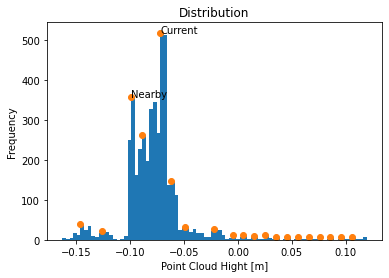

In [55]:
##### original #####
inlier_np = np.asarray(inlier_pcd.points)
viz_o3d_pc([ xyz_mesh, inlier_pcd ])
print('all', inlier_pcd)

##### estimate 2 plane height (y axis) #####
height_threshold_all = [-0.07539-0.2, -0.07539+0.2] ##### all range
# inlier_np[:, 1] = inlier_np[:, 1]-0.25+0.07539
# height_threshold_all = [-0.25-0.2, -0.25+0.2] ##### all range

height_range = abs(height_threshold_all[0]-height_threshold_all[1])
print('range', height_range)
pcd_low_all = np_pc_to_o3d_pc(inlier_np[ (inlier_np[:, 1] > height_threshold_all[0]) & (inlier_np[:, 1] < height_threshold_all[1]) ])
viz_o3d_pc([ xyz_mesh, pcd_low_all ])

y_height = np.asanyarray(pcd_low_all.points)[:, 1]

# plot distribution
n, bins, patches = plt.hist(y_height, bins= int(abs(y_height.max() - y_height.min())*100*3), density=False) # n: 包含每个bin中的数据量或概率的数组, # bins: 包含bin的边界值的数组 (比bin数多一个因为包括左右两边)
plt.xlabel('Point Cloud Hight [m]')
plt.ylabel('Frequency')
plt.title('Distribution')

# find peaks
peaks, _ = find_peaks(n, distance=3)
# plot peaks
plt.plot(bins[peaks], n[peaks], 'o')

# 峰值点对应的bin的数值
print('peak value:', bins[peaks])
# 峰值点对应的bin的数量
print('peak num:', n[peaks])
# 对数组进行排序，并取前两个大的元素
max_values = sorted(n[peaks], reverse=True)[:2] # big to small
max_ids = np.argsort(n[peaks])[-2:] # big to small
print('最多的两个bin的个数是:', max_values)
print('最多的两个bin的索引是:', max_ids)
estimated_height_few, estimated_height_many = bins[peaks][max_ids]
print('估计出来的两个平面的高度:', estimated_height_many, estimated_height_few)
estimated_height_low1, estimated_height_low2 = min(estimated_height_many, estimated_height_few), max(estimated_height_many, estimated_height_few)

# 多的一组：当前行驶道路；少的一组：旁边道路
plt.annotate('Current', (estimated_height_many, max_values[0]), xytext=None, arrowprops=None) # num: many
plt.annotate('Nearby', (estimated_height_few, max_values[1]), xytext=None, arrowprops=None) # num: few
plt.show()

In [56]:
middle_height = abs(estimated_height_low1 - estimated_height_low2)/2

# 1st low (lowest)
height_threshold1 = [estimated_height_low1-0.10, estimated_height_low1+middle_height] #####
print('range:', height_threshold1)
low1_id = (inlier_np[:, 1] > height_threshold1[0]) & (inlier_np[:, 1] < height_threshold1[1])
pcd_low1_np = inlier_np[ low1_id ] # point 
color_low1_np = np.asarray(inlier_pcd.colors)[low1_id] # color
pcd_low1 = np_to_o3d(pcd_low1_np, color_low1_np) # point + color
# pcd_low1 = np_pc_to_o3d_pc(pcd_low1_np) # only point
viz_o3d_pc([ xyz_mesh, pcd_low1 ])
print('low1', pcd_low1)

# 2nd low
# height_threshold2 = [estimated_height_low1, estimated_height_low1+middle_height] ##### for check only 1 plane to RANSAC
height_threshold2 = [estimated_height_low2-middle_height, estimated_height_low2+0.10] #####
print('range:', height_threshold2)
low2_id = (inlier_np[:, 1] > height_threshold2[0]) & (inlier_np[:, 1] < height_threshold2[1])
pcd_low2_np = inlier_np[ low2_id ] # point 
color_low2_np = np.asarray(inlier_pcd.colors)[ low2_id ] # color
pcd_low2 = np_to_o3d(pcd_low2_np, color_low2_np) # point + color
# pcd_low2 = np_pc_to_o3d_pc(pcd_low2_np) # only point
viz_o3d_pc([ xyz_mesh, pcd_low2 ])
print('low2', pcd_low2)

range: [-0.198953825771777, -0.08552524100314983]
low1 geometry::PointCloud with 1498 points.
range: [-0.08552524100314983, 0.02790334376547733]
low2 geometry::PointCloud with 2900 points.


### RANSAC (multi: road1 & road2)

In [57]:
##### RANSAC #####
plane_model1, plane_index1 = pcd_low1.segment_plane(distance_threshold=0.01, ransac_n=100, num_iterations=100) # 1cm
plane_model2, plane_index2 = pcd_low2.segment_plane(distance_threshold=0.01, ransac_n=100, num_iterations=100) # 1cm

##### viz estimated plane
# road 1 (low1/lowest) 
# a, b, c, d = 0, 0, 1, 0
[a_road1, b_road1, c_road1, d_road1] = plane_model1
print('plane parameters (road 1):', a_road1, b_road1, c_road1, d_road1) # ax + by + cz + d = 0
xx_road1, zz_road1 = np.meshgrid(np.arange(-3, 3, 0.1), np.arange(-10, 0, 0.1))
yy_road1 = (- a_road1*xx_road1 - c_road1*zz_road1 - d_road1) / b_road1 # according to: ax + by + cz + d = 0
plane_road1 = np.vstack((xx_road1.ravel(), yy_road1.ravel(), zz_road1.ravel())).T
# road 2 (low2) 
[a_road2, b_road2, c_road2, d_road2] = plane_model2
print('plane parameters (road 2):', a_road2, b_road2, c_road2, d_road2) # ax + by + cz + d = 0
xx_road2, zz_road2 = np.meshgrid(np.arange(-3, 3, 0.1), np.arange(-10, 0, 0.1))
yy_road2 = (- a_road2*xx_road2 - c_road2*zz_road2 - d_road2) / b_road2 # according to: ax + by + cz + d = 0
plane_road2 = np.vstack((xx_road2.ravel(), yy_road2.ravel(), zz_road2.ravel())).T

##### distinguish road1, road2, obstacle; and color
# road 1 -> black
road_pcd1 = pcd_low1.select_by_index(plane_index1)
road_pcd1.paint_uniform_color([0, 0, 0])
print('road 1 (lowest):', road_pcd1)
# road 2 -> red
road_pcd2 = pcd_low2.select_by_index(plane_index2)
road_pcd2.paint_uniform_color([1, 0, 0])
print('road 2 (low2):', road_pcd2)
# # outlier (obstacle)
# obstacle_pcd = pcd_low.select_by_index(plane_index, invert=True)

# calculate diff of all & (road 1 + road 2) (for get real obstacle) -> blue
road1_road2_np = np.concatenate((np.asarray(road_pcd1.points), np.asarray(road_pcd2.points)), axis=0)
obstacle_np, index = calc_array2d_diff_index(np.asarray(inlier_pcd.points), road1_road2_np) # point 
color_obstacle_np = np.asarray(inlier_pcd.colors)[index] # color 
obstacle_pcd = np_to_o3d(obstacle_np, color_obstacle_np) # point + color
obstacle_pcd.paint_uniform_color([0, 0, 1])
print('obstacle:', obstacle_pcd)

viz_o3d_pc([xyz_mesh, road_pcd1, road_pcd2, obstacle_pcd, np_pc_to_o3d_pc(plane_road1), np_pc_to_o3d_pc(plane_road2)])

plane parameters (road 1): -0.12876179342147903 0.991675549371907 7.302609592181535e-05 0.07556941636860297
plane parameters (road 2): -0.06340553808751505 0.9979742416246603 0.0052106423324644125 0.08561999709018706
road 1 (lowest): geometry::PointCloud with 1387 points.
road 2 (low2): geometry::PointCloud with 2521 points.
obstacle: geometry::PointCloud with 963 points.


### RANSAC (single: road1)

In [58]:
# ##### RANSAC #####
# plane_model3, plane_index3 = inlier_pcd.segment_plane(distance_threshold=0.01, ransac_n=100, num_iterations=100) # 1cm

# ##### viz estimated plane
# # road
# [a_road3, b_road3, c_road3, d_road3] = plane_model3
# print('plane parameters (road 3):', a_road3, b_road3, c_road3, d_road3) # ax + by + cz + d = 0
# xx_road3, zz_road3 = np.meshgrid(np.arange(-3, 3, 0.1), np.arange(-10, 0, 0.1))
# yy_road3 = (- a_road3*xx_road3 - c_road3*zz_road3 - d_road3) / b_road3 # according to: ax + by + cz + d = 0
# plane_road3 = np.vstack((xx_road3.ravel(), yy_road3.ravel(), zz_road3.ravel())).T


# ##### distinguish road1, road2, obstacle; and color
# # road 1 -> black
# road_pcd3 = inlier_pcd.select_by_index(plane_index3)
# road_pcd3.paint_uniform_color([0, 0, 0])
# print('road (single):', road_pcd3)
# # outlier (obstacle) -> blue
# obstacle_pcd_single = inlier_pcd.select_by_index(plane_index3, invert=True)
# obstacle_pcd_single.paint_uniform_color([0, 0, 1])
# print('obstacle (single):', obstacle_pcd_single)


# viz_o3d_pc([xyz_mesh, road_pcd3, obstacle_pcd_single, np_pc_to_o3d_pc(plane_road3)])

## 6. cluster obstacle
## k-means: need to specify the cluster number (NG), or DBScan: 以点的密度大小进行聚类, 
</div>
<img src='./figs/clustering.png' width='400'/>
</div>

### or HDBScan, or KD-Tree: fast search speed, 加入法向量信息，因为墙，地面，障碍物的法向量不同，容易区分
<div>
<img src='./figs/KD-Tree.png' width='250'/>
</div>

### o3d (DBSCAN) + matplotlib (viz)

##### for RGB

In [59]:
otstacle_np_object = np.asarray(inlier_pcd_object.points).astype(np.float32)

##### DBSCAN #####
labels_object = np.array(inlier_pcd_object.cluster_dbscan(eps=0.03, min_points=25, print_progress=False)) # for small object

# cluster num
max_label_object = labels_object.max()
n_clusters_object = max_label_object + 1
print('small cluster number (except noise):', n_clusters_object)

# viz
colors_object = plt.get_cmap('tab20')(labels_object / max(max_label_object, 1))
colors_object[labels_object < 0] = 0 # if noise, set color as black:[0, 0, 0]/white:[1, 1, 1], otherwise [r, g, b]
inlier_pcd_object.colors = o3d.utility.Vector3dVector(colors_object[:, :3])
viz_o3d_pc([xyz_mesh, inlier_pcd_object])

small cluster number (except noise): 4


##### for binocular

In [60]:
# # just an example
# obstacle_pcd = o3d.io.read_point_cloud(r'./data/fragment.pcd') 

otstacle_np = np.asarray(obstacle_pcd.points).astype(np.float32)

##### DBSCAN #####
# eps: euclidean distance thresold. (if sparse, set big value; if dense, seg small value)
# min_points: how many points (at least) per 1 cluster 
# labels: -1: no-cluster (noise)
labels_small = np.array(obstacle_pcd.cluster_dbscan(eps=0.05, min_points=30, print_progress=False)) # for small object
labels_big = np.array(obstacle_pcd.cluster_dbscan(eps=0.2, min_points=200, print_progress=False))  # for big object

# cluster num
max_label_small = labels_small.max()
max_label_big = labels_big.max()
n_clusters_small = max_label_small + 1
n_clusters_big = max_label_big + 1
print('small cluster number (except noise):', n_clusters_small)
print('big cluster number (except noise):', n_clusters_big)

# viz
colors_small = plt.get_cmap('tab20')(labels_small / max(max_label_small, 1))
colors_big = plt.get_cmap('tab20')(labels_big / max(max_label_big, 1))

colors_small[labels_small < 0] = 0 # if noise, set color as black:[0, 0, 0]/white:[1, 1, 1], otherwise [r, g, b]
colors_big[labels_big < 0] = 0 # if noise, set color as black:[0, 0, 0]/white:[1, 1, 1], otherwise [r, g, b]

obstacle_pcd.colors = o3d.utility.Vector3dVector(colors_small[:, :3])
viz_o3d_pc([xyz_mesh, obstacle_pcd])

obstacle_pcd.colors = o3d.utility.Vector3dVector(colors_big[:, :3])
viz_o3d_pc([xyz_mesh, obstacle_pcd])

small cluster number (except noise): 7
big cluster number (except noise): 1


## 7. fit each cluster to 3D box (PCA, or 最小凸包法, or OBB/轴对齐, or AABB/有方向)
PS: 根据点云的x, y坐标找到x, y的最大值和最小值的点 (共有4个点), 根据这4个点画出矩形框很显然是不行的。但是如果知道车辆的朝向，以朝向为轴找到距离轴最大最小的点，此方法画出的边界框更加精确。
<div>
<img src='./figs/PCA.png' width='400'/>
</div>

##### for RGB

In [61]:
##### 3D BBox from rgb (green) #####
objects_object = []
box_object = []
for i in range(n_clusters_object):
    num_pcd_object = len(otstacle_np_object[labels_object == i]) # pcd number of 'per object'
    print('cluster small', i, '->', num_pcd_object)

    object = np_pc_to_o3d_pc(otstacle_np_object[labels_object == i]) # pcd of 'per object' 
    aabb = object.get_axis_aligned_bounding_box() ### AABB(轴对其包围盒:Axis-Aligned Bounding Box) 
    aabb.color = (0, 1, 0) # green
    # obb = bottle.get_oriented_bounding_box(robust=True) ### OBB(有向包围盒:Oriented Bounding Box), error
    # obb.color = (0, 1, 0) # green
    objects_object.append(object)
    box_object.append(aabb)

viz_o3d_pc([xyz_mesh] + objects_object + box_object)

cluster small 0 -> 700
cluster small 1 -> 66
cluster small 2 -> 182
cluster small 3 -> 42


##### for binocular

In [62]:
##### small 3D BBox (red) #####
objects_small = []
box_small = []
for i in range(n_clusters_small):
    num_pcd = len(otstacle_np[labels_small == i]) # pcd number of 'per object'
    print('cluster small', i, '->', num_pcd)

    object = np_pc_to_o3d_pc(otstacle_np[labels_small == i]) # pcd of 'per object' 
    aabb = object.get_axis_aligned_bounding_box() ### AABB(轴对其包围盒:Axis-Aligned Bounding Box) 
    aabb.color = (1, 0, 0) # red
    # obb = bottle.get_oriented_bounding_box(robust=True) ### OBB(有向包围盒:Oriented Bounding Box), error
    # obb.color = (0, 1, 0) # green
    objects_small.append(object)
    box_small.append(aabb)


##### big 3D BBox (blue) #####
objects_big = []
box_big = []
for i in range(n_clusters_big):
    num_pcd = len(otstacle_np[labels_big == i]) # pcd number of 'per object'
    print('cluster big', i, '->', num_pcd)

    object = np_pc_to_o3d_pc(otstacle_np[labels_big == i]) # pcd of 'per object' 
    aabb = object.get_axis_aligned_bounding_box()
    aabb.color = (0, 0, 1) # blue
    # obb = bottle.get_oriented_bounding_box(robust=True)
    # obb.color = (0, 1, 0) # green
    objects_big.append(object)
    box_big.append(aabb)

# viz
viz_o3d_pc([xyz_mesh] + objects_small + box_small + objects_big + box_big)

cluster small 0 -> 42
cluster small 1 -> 40
cluster small 2 -> 42
cluster small 3 -> 35
cluster small 4 -> 131
cluster small 5 -> 259
cluster small 6 -> 40
cluster big 0 -> 544


## 8. refine 3D box 
计算两个box之间的关系来判断是不是一个物体: 1. IoU (两个大小相似的可以,但是一大一小没有用), 2. 计算交集部分的体积占小的box的体积的百分比

<div>
<img src='./figs/fomula1.png' width='400'/>
</div>

##### for binocular

In [63]:
if len(box_small) != 0 and len(box_big) != 0: # only both small and big exist
    box_small_processed = []
    objects_small_processed = []

    ids = []
    c = 0
    for box_s in box_small: ##### small
        for box_b in box_big: ##### big
            # viz_o3d_pc([xyz_mesh, box, np_pc_to_o3d_pc(np.array([box.get_center()]))]) # viz box & center
            
            x_1, y_1, z_1 = box_s.get_center() # center coord of x, y, z
            l_1, w_1, h_1 = box_s.get_extent() # length of x, y, z
            box1 = (x_1, y_1, z_1, l_1, w_1, h_1) # 第一个长方体的中心坐标，长宽高

            x_2, y_2, z_2 = box_b.get_center()
            l_2, w_2, h_2 = box_b.get_extent()
            box2 = (x_2, y_2, z_2, l_2, w_2, h_2) # 第二个长方体的中心坐标，长宽高

            ##### calculate intersection (overlap volume)
            v_c = box_intersection_volume(*box1, *box2)

            if v_c > 0: # if overlap only
                v_1 = l_1 * w_1 * h_1 # volume 1
                v_2 = l_2 * w_2 * h_2 # volume 2
                v_small = min(v_1, v_2) # small volume
                if (v_c / v_small) < (0.3 * 0.3 * 0.3): # only small one when overlap/small is smaller than 0.3 times
                    box_small_processed.append(box_s)
                    objects_small_processed.append(objects_small[c])
            else: # if not overlap
                box_small_processed.append(box_s)
                objects_small_processed.append(objects_small[c])
                print(objects_small[c])

        c += 1
    # viz
    viz_o3d_pc([xyz_mesh] + box_small_processed + objects_small_processed + box_big + objects_big)
    # viz_o3d_pc([xyz_mesh]  + box_big + objects_big)

else:
    box_small_processed = box_small
    objects_small_processed = objects_small

    # viz
    viz_o3d_pc([xyz_mesh] + box_small_processed + objects_small_processed + box_big + objects_big)
    # viz_o3d_pc([xyz_mesh]   + box_big + objects_big)

geometry::PointCloud with 42 points.
geometry::PointCloud with 40 points.


In [64]:
for i, box in enumerate(box_small_processed + box_big):
# for i, box in enumerate(box_big):
    # print('object id:', i)
    points_8 = np.array(box.get_box_points()) # 8 bounding box

    highest_height = max(points_8[:, 1]) + 0.05
    # print('max height: {} [m]'.format(highest_height))
    
    dist_8 = []
    for point_1 in points_8:
        dist_8.append(np.linalg.norm(point_1))

    min_dist = min(dist_8)
    # print('min distant: {} [m]'.format(min_dist))

    if highest_height > 0.075 and min_dist < 2.5:
        print('!! dangerous id !!', i)
        print('max height: {:.3f} [m]'.format(highest_height))
        print('min distant: {:.3f} [m]'.format(min_dist))
        if box.get_center()[0] >= 0:
            print('right')
        else:
            print('left')
        print()
    
    else:
        print('no danger found')

no danger found
!! dangerous id !! 1
max height: 0.082 [m]
min distant: 2.389 [m]
right

no danger found


##### for RGB

In [65]:
# otstacle_np = np.asarray(inlier_pcd_object.points).astype(np.float32)

##### DBSCAN #####
labels_small = np.array(inlier_pcd_object.cluster_dbscan(eps=0.05, min_points=30, print_progress=False)) # for small object
# labels_big = np.array(obstacle_pcd.cluster_dbscan(eps=0.2, min_points=200, print_progress=False))  # for big object

# cluster num
max_label_small = labels_small.max()
# max_label_big = labels_big.max()
n_clusters_small = max_label_small + 1
# n_clusters_big = max_label_big + 1
print('small cluster number (except noise):', n_clusters_small)
# print('big cluster number (except noise):', n_clusters_big)

# viz
colors_small = plt.get_cmap('tab20')(labels_small / max(max_label_small, 1))
# colors_big = plt.get_cmap('tab20')(labels_big / max(max_label_big, 1))

colors_small[labels_small < 0] = 0 # if noise, set color as black:[0, 0, 0]/white:[1, 1, 1], otherwise [r, g, b]
# colors_big[labels_big < 0] = 0 # if noise, set color as black:[0, 0, 0]/white:[1, 1, 1], otherwise [r, g, b]

inlier_pcd_object.colors = o3d.utility.Vector3dVector(colors_small[:, :3])
viz_o3d_pc([xyz_mesh, inlier_pcd_object])

# obstacle_pcd.colors = o3d.utility.Vector3dVector(colors_big[:, :3])
# viz_o3d_pc([xyz_mesh, obstacle_pcd])



##### object detection
viz_o3d_pc([xyz_mesh] + objects_object + box_object + box_small_processed + objects_small_processed + box_big + objects_big)

small cluster number (except noise): 5


##### KMeans (sklearn) + k3d (viz)
##### DBSCAN (sklearn) + k3d (viz)
##### [cluster point cloud via k-means, DBScan, HDBSCAN](https://tech-deliberate-jiro.com/clustering/)

In [67]:
# ##### only points #####
# otstacle_np = np.asarray(obstacle_pcd.points).astype(np.float32) # point
# X = otstacle_np

# # ##### points & color #####
# # otstacle_np = np.asarray(obstacle_pcd.points).astype(np.float32) # point
# # otstacle_color_np = np.asarray(obstacle_pcd.colors).astype(np.float32) # color
# # X = np.concatenate([otstacle_np, otstacle_color_np/5], axis=1)

# # ##### k-means #####
# # kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10, max_iter=500).fit(X) # , random_state=9
# # labels = kmeans.labels_

# ##### DBSCAN #####
# # dbscan = DBSCAN(eps=0.05, min_samples=20).fit(X) # for small object
# dbscan = DBSCAN(eps=0.5, min_samples=200).fit(X) # for big object
# labels = dbscan.labels_

# # cluster num
# n_clusters = labels.max() + 1
# print('cluster number (except noise):', n_clusters)

# # viz
# col = cal_color(1000)
# plot = k3d.plot()
# for i in range(n_clusters):
#     plot += k3d.points(otstacle_np[labels==i], point_size=0.01, color = int(col[i],16))
# plot.display()

In [24]:
# ##### cross validation
# o3d.ml.torch.cv.CrossValidator
# ##### grid search
# o3d.ml.torch.hyper_param_search.grid_search

In [25]:
# 1. 将深度图和遮罩图像加载为numpy数组。
# 2. 将深度图和遮罩图像中不需要的部分都设置为0。
# 3. 将深度图和遮罩图像乘起来，这样就只会保留需要的部分。
# 4. 将结果传递给深度图转点云的函数，如open3d中的create_point_cloud_from_depth_image。

# # 加载深度图和遮罩图像
# depth_image = np.load('depth.npy')
# mask_image = np.load('mask.npy')

# # 将深度图和遮罩图像中不需要的部分都设置为0
# depth_image *= mask_image

# # 将深度图转换为点云
# intrinsics = o3d.camera.PinholeCameraIntrinsic(width=depth_image.shape[1], height=depth_image.shape[0], fx=525.0, fy=525.0, cx=319.5, cy=239.5)
# point_cloud = o3d.geometry.PointCloud.create_from_depth_image(o3d.geometry.Image(depth_image), intrinsics)

# # 可以将点云可视化来检查结果
# o3d.visualization.draw_geometries([point_cloud])
